In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [2]:
import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [ ]:
# statistics
from scipy.optimize import curve_fit
from scipy import stats

In [3]:
__all__ = ['KitaevLadder', 'KitaevLadderModel']

In [4]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        nNNa = [(1, 2, np.array([0])), (3, 0, np.array([1]))]
        nNNb = [(0, 3, np.array([0])), (2, 1, np.array([1]))]
        
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        kwargs['pairs'].setdefault('next_nearest_neighbors_a', nNNa)
        kwargs['pairs'].setdefault('next_nearest_neighbors_b', nNNb)
        
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
         
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [5]:
class Ising1D(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 0., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 0., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
        for u1, u2, dx in self.lat.pairs['next_nearest_neighbors_a']:
            self.add_coupling(-Jz, u1, 'Sx', u2, 'Sx', dx)
    pass


In [6]:
def run(calc_correlation=True):

    model_params = dict(conserve=None, Jx=1., Jy=1., Jz=0., L=1, verbose=1)
    prod_state = ["up", "up"] * (2 * model_params['L'])
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-8,
        'max_sweeps': 1000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    # we will return this data dictionary in the end, for the further investigation
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = [int(2**i) for i in np.arange(4, 7, 0.5)]
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [7]:
def plot_results(data):

    chi_list = data['chi_list']
    energy_list = data['energy_list']
    entropy_list = data['entropy_list']
    correlation_list = data['correlation_list']
    
    plt.plot(chi_list, energy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Ground Energy $E$")
    plt.show()
    
    plt.plot(chi_list, entropy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    
    plt.plot(chi_list, correlation_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Correlation Length $\xi$")
    plt.show()
    
    plt.plot(np.log(correlation_list), entropy_list, '-o')
    plt.xlabel(r"log Correlation Length $\xi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()

In [8]:
data = run()

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=1.0 for KitaevLadderModel
parameter 'Jz'=0.0 for KitaevLadderModel


==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=1000 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-08 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591281685345969, S = nan, norm_err = 1.4e-03
Current memory usage 124.6 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7601e-06, max_E_trunc =

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
DMRG finished after 120 sweeps.
total size = 1604, maximum chi = 16
Before the canonicalization:
Bond dim =  [16, 16, 16, 16]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000888134-2.426443138533579e-16j)
After the canonicalization:
Bond dim =  [16, 16, 16, 16]
Computing properties
Optimizing
Loop for chi=16 done.
============================== END ==============================


==============================START==============================
Chi =  22 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591473260927163, S = nan, norm_err = 5.0e-04
Current memory usage 127.9 MB, time elapsed: 1.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.4969e-06, max_E_trunc = 6.9687e-06
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591475876937629, S = nan, norm_err = 2.2e-04
Current memory usage 127.9 MB, time elapsed: 3.6 s
Delta E = -2.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
DMRG finished after 170 sweeps.
total size = 2204, maximum chi = 22
Before the canonicalization:
Bond dim =  [22, 22, 22, 22]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000603358+1.8324255500690384e-16j)
After the canonicalization:
Bond dim =  [22, 22, 22, 22]
Computing properties
Optimizing
Loop for chi=22 done.
============================== END ==============================


==============================START==============================
Chi =  32 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591500719948664, S = nan, norm_err = 1.7e-03
Current memory usage 131.5 MB, time elapsed: 2.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4546e-06, max_E_trunc = 2.5857e-06
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591509704768042, S = nan, norm_err = 1.2e-03
Current memory usage 131.5 MB, time elap

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591520453326325, S = 0.8529414041260155, norm_err = 5.3e-06
Current memory usage 132.8 MB, time elapsed: 26.9 s
Delta E = -3.3616e-12, Delta S = -7.6869e-06 (per sweep)
max_trunc_err = 1.3091e-06, max_E_trunc = 2.7211e-06
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591520453520658, S = 0.8528892709438709, norm_err = 4.5e-06
Current memory usage 133.0 MB, time elapsed: 28.2 s
Delta E = -1.9433e-12, Delta S = -5.2133e-06 (per sweep)
max_trunc_err = 1.3100e-06, max_E_trunc = 2.7226e-06
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591520453635127, S = 0.8528538844367718, norm_err = 4.1e-06
Current memory usage 133.0 MB, time elapsed: 29.6 s
Delta E = -1.1447e-12, Delta S = -3.5387e-06 (per sweep)
max_trunc_err = 1.3107e-06, max_E_trunc = 2.7237e-06
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 2

..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591512091895488, S = nan, norm_err = 8.7e-04
Current memory usage 140.8 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.9458e-07, max_E_trunc = 1.0011e-06
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591522219501877, S = nan, norm_err = 1.4e-03
Current memory usage 142.1 MB, time elapsed: 5.3 s
Delta E = -1.0128e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4018e-06, max_E_trunc = 1.3889e-06
MPS bond dimensions: [45, 45, 45, 45]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 444
Energy = -0.1591525242264744, S = 1.1195468252680498, norm_err = 1.4e-03
Current memory usage 142.1 MB, time elapsed: 7.5 s
Delta E = -3.0228e-08, Delta S = nan (per sweep)
max_trunc_err = 1.6999e-06, max_E_trunc = 1.6586e-06
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
...

Updating environment
.....
sweep 220, age = 2724
Energy = -0.1591537094708997, S = 0.9362997653115509, norm_err = 5.2e-05
Current memory usage 143.9 MB, time elapsed: 34.1 s
Delta E = -1.6169e-10, Delta S = -1.6867e-04 (per sweep)
max_trunc_err = 6.9559e-07, max_E_trunc = 1.3555e-06
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 230, age = 2844
Energy = -0.1591537104638263, S = 0.9349697963476232, norm_err = 4.1e-05
Current memory usage 143.9 MB, time elapsed: 35.5 s
Delta E = -9.9293e-11, Delta S = -1.3300e-04 (per sweep)
max_trunc_err = 6.9280e-07, max_E_trunc = 1.3510e-06
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 240, age = 2964
Energy = -0.1591537110648389, S = 0.9339376432685536, norm_err = 3.2e-05
Current memory usage 144.7 MB, time elapsed: 36.9 s
Delta E = -6.0101e-11, Delta S = -1.0322e-04 (per sweep)
max_trunc_err = 6.9068e-07, max_E_trunc = 1.3476e-06
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 2

Updating environment
.....
sweep 430, age = 5244
Energy = -0.1591537118684272, S = 0.9303001229804446, norm_err = 1.6e-06
Current memory usage 147.5 MB, time elapsed: 63.0 s
Delta E = 9.0949e-14, Delta S = -8.7850e-07 (per sweep)
max_trunc_err = 6.8382e-07, max_E_trunc = 1.3368e-06
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 440, age = 5364
Energy = -0.1591537118679724, S = 0.9302928698916682, norm_err = 1.6e-06
Current memory usage 147.5 MB, time elapsed: 64.3 s
Delta E = 4.5475e-14, Delta S = -7.2531e-07 (per sweep)
max_trunc_err = 6.8380e-07, max_E_trunc = 1.3367e-06
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 450, age = 5484
Energy = -0.1591537118674040, S = 0.9302875307512368, norm_err = 1.6e-06
Current memory usage 147.5 MB, time elapsed: 65.7 s
Delta E = 5.6843e-14, Delta S = -5.3391e-07 (per sweep)
max_trunc_err = 6.8379e-07, max_E_trunc = 1.3367e-06
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 460,

..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591527776312476, S = nan, norm_err = 7.3e-04
Current memory usage 154.5 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7096e-07, max_E_trunc = 3.8829e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591534977100428, S = nan, norm_err = 9.4e-04
Current memory usage 155.5 MB, time elapsed: 6.8 s
Delta E = -7.2008e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.5564e-07, max_E_trunc = 4.7950e-07
MPS bond dimensions: [64, 64, 64, 64]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 444
Energy = -0.1591537300929851, S = 1.2152968413087004, norm_err = 8.2e-04
Current memory usage 156.8 MB, time elapsed: 9.6 s
Delta E = -2.3238e-08, Delta S = nan (per sweep)
max_trunc_err = 5.5552e-07, max_E_trunc = 5.8091e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
...

Updating environment
.....
sweep 220, age = 2724
Energy = -0.1591542482956143, S = 1.1328367393329710, norm_err = 4.9e-04
Current memory usage 160.6 MB, time elapsed: 43.8 s
Delta E = -2.5061e-09, Delta S = -1.1024e-03 (per sweep)
max_trunc_err = 3.0527e-07, max_E_trunc = 6.2898e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 230, age = 2844
Energy = -0.1591542724356287, S = 1.1220599399424445, norm_err = 4.6e-04
Current memory usage 160.6 MB, time elapsed: 45.5 s
Delta E = -2.4140e-09, Delta S = -1.0777e-03 (per sweep)
max_trunc_err = 2.9423e-07, max_E_trunc = 6.0647e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 240, age = 2964
Energy = -0.1591542953348153, S = 1.1116294210519868, norm_err = 4.2e-04
Current memory usage 160.6 MB, time elapsed: 47.4 s
Delta E = -2.2899e-09, Delta S = -1.0431e-03 (per sweep)
max_trunc_err = 2.8373e-07, max_E_trunc = 5.8504e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 2

Updating environment
.....
sweep 430, age = 5244
Energy = -0.1591544748442004, S = 1.0160998514817174, norm_err = 3.3e-05
Current memory usage 165.5 MB, time elapsed: 82.8 s
Delta E = -7.9301e-11, Delta S = -1.2182e-04 (per sweep)
max_trunc_err = 2.4390e-07, max_E_trunc = 5.1516e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 440, age = 5364
Energy = -0.1591544754521550, S = 1.0150738697386958, norm_err = 3.0e-05
Current memory usage 165.5 MB, time elapsed: 84.6 s
Delta E = -6.0795e-11, Delta S = -1.0260e-04 (per sweep)
max_trunc_err = 2.4411e-07, max_E_trunc = 5.1519e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 450, age = 5484
Energy = -0.1591544759297108, S = 1.0142135909691168, norm_err = 2.7e-05
Current memory usage 165.5 MB, time elapsed: 86.6 s
Delta E = -4.7756e-11, Delta S = -8.6028e-05 (per sweep)
max_trunc_err = 2.4441e-07, max_E_trunc = 5.1546e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 640, age = 7764
Energy = -0.1591544796920914, S = 1.0103831216153973, norm_err = 4.8e-06
Current memory usage 170.4 MB, time elapsed: 122.9 s
Delta E = -1.8218e-12, Delta S = -2.9610e-06 (per sweep)
max_trunc_err = 2.3671e-07, max_E_trunc = 5.0408e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 650, age = 7884
Energy = -0.1591544797079791, S = 1.0103580381729533, norm_err = 4.5e-06
Current memory usage 170.7 MB, time elapsed: 124.7 s
Delta E = -1.5888e-12, Delta S = -2.5083e-06 (per sweep)
max_trunc_err = 2.3667e-07, max_E_trunc = 5.0399e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 660, age = 8004
Energy = -0.1591544797215079, S = 1.0103367950711968, norm_err = 4.2e-06
Current memory usage 171.2 MB, time elapsed: 126.5 s
Delta E = -1.3529e-12, Delta S = -2.1243e-06 (per sweep)
max_trunc_err = 2.3663e-07, max_E_trunc = 5.0392e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
swee

Updating environment
.....
sweep 850, age = 10284
Energy = -0.1591544797911695, S = 1.0102244929736848, norm_err = 2.4e-06
Current memory usage 177.1 MB, time elapsed: 161.4 s
Delta E = -1.9895e-14, Delta S = -9.0376e-08 (per sweep)
max_trunc_err = 2.3645e-07, max_E_trunc = 5.0354e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 860, age = 10404
Energy = -0.1591544797916526, S = 1.0102237260979778, norm_err = 2.4e-06
Current memory usage 177.1 MB, time elapsed: 163.3 s
Delta E = -4.8317e-14, Delta S = -7.6688e-08 (per sweep)
max_trunc_err = 2.3645e-07, max_E_trunc = 5.0355e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
sweep 870, age = 10524
Energy = -0.1591544797921642, S = 1.0102230771180514, norm_err = 2.3e-06
Current memory usage 177.4 MB, time elapsed: 165.3 s
Delta E = -5.1159e-14, Delta S = -6.4898e-08 (per sweep)
max_trunc_err = 2.3645e-07, max_E_trunc = 5.0354e-07
MPS bond dimensions: [64, 64, 64, 64]
Updating environment
.....
s

Updating environment
.....
sweep 40, age = 564
Energy = -0.1591542790527427, S = 1.2391339323765915, norm_err = 1.4e-03
Current memory usage 215.3 MB, time elapsed: 19.0 s
Delta E = -2.2884e-08, Delta S = 5.5797e-04 (per sweep)
max_trunc_err = 1.4116e-07, max_E_trunc = 2.7733e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 50, age = 684
Energy = -0.1591543909864193, S = 1.2586157250005308, norm_err = 5.8e-04
Current memory usage 215.3 MB, time elapsed: 22.7 s
Delta E = -1.1193e-08, Delta S = 1.9482e-03 (per sweep)
max_trunc_err = 1.5072e-07, max_E_trunc = 2.9943e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 60, age = 804
Energy = -0.1591544350996585, S = 1.2602658182956363, norm_err = 5.7e-04
Current memory usage 215.3 MB, time elapsed: 26.3 s
Delta E = -4.4113e-09, Delta S = 1.6501e-04 (per sweep)
max_trunc_err = 1.7503e-07, max_E_trunc = 3.4480e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 70, age = 

Updating environment
.....
sweep 250, age = 3084
Energy = -0.1591546744519903, S = 1.1838703414209992, norm_err = 3.0e-04
Current memory usage 215.3 MB, time elapsed: 75.5 s
Delta E = -6.9277e-10, Delta S = -7.4683e-04 (per sweep)
max_trunc_err = 1.3297e-07, max_E_trunc = 2.5886e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 260, age = 3204
Energy = -0.1591546482789141, S = 1.1787819092231300, norm_err = 6.0e-04
Current memory usage 215.3 MB, time elapsed: 78.8 s
Delta E = 2.6173e-09, Delta S = -5.0884e-04 (per sweep)
max_trunc_err = 1.3821e-07, max_E_trunc = 2.6631e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 270, age = 3324
Energy = -0.1591546858174411, S = 1.1722664588434681, norm_err = 8.6e-05
Current memory usage 215.3 MB, time elapsed: 81.6 s
Delta E = -3.7539e-09, Delta S = -6.5155e-04 (per sweep)
max_trunc_err = 1.4699e-07, max_E_trunc = 2.8416e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 28

Updating environment
.....
sweep 460, age = 5604
Energy = -0.1591547496370680, S = 1.0973458975495562, norm_err = 6.5e-05
Current memory usage 215.5 MB, time elapsed: 144.7 s
Delta E = -3.4973e-11, Delta S = -1.7868e-04 (per sweep)
max_trunc_err = 9.6040e-08, max_E_trunc = 1.9253e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 470, age = 5724
Energy = -0.1591547488711171, S = 1.0975851820768725, norm_err = 1.7e-04
Current memory usage 215.5 MB, time elapsed: 149.8 s
Delta E = 7.6595e-11, Delta S = 2.3928e-05 (per sweep)
max_trunc_err = 1.0985e-07, max_E_trunc = 2.1397e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 480, age = 5844
Energy = -0.1591547521523751, S = 1.0927826965936398, norm_err = 2.0e-04
Current memory usage 215.5 MB, time elapsed: 158.8 s
Delta E = -3.2813e-10, Delta S = -4.8025e-04 (per sweep)
max_trunc_err = 1.0298e-07, max_E_trunc = 2.0314e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 

Updating environment
.....
sweep 670, age = 8124
Energy = -0.1591547597617762, S = 1.0838169738723331, norm_err = 7.9e-05
Current memory usage 215.5 MB, time elapsed: 323.3 s
Delta E = 1.0203e-11, Delta S = -3.5770e-05 (per sweep)
max_trunc_err = 9.3841e-08, max_E_trunc = 1.8230e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 680, age = 8244
Energy = -0.1591547594525196, S = 1.0832109611061258, norm_err = 1.1e-04
Current memory usage 215.5 MB, time elapsed: 329.6 s
Delta E = 3.0926e-11, Delta S = -6.0601e-05 (per sweep)
max_trunc_err = 9.4146e-08, max_E_trunc = 1.8278e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 690, age = 8364
Energy = -0.1591547598808063, S = 1.0843273427512923, norm_err = 7.7e-05
Current memory usage 219.1 MB, time elapsed: 337.6 s
Delta E = -4.2829e-11, Delta S = 1.1164e-04 (per sweep)
max_trunc_err = 9.4764e-08, max_E_trunc = 1.8380e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 7

Updating environment
.....
sweep 880, age = 10644
Energy = -0.1591547596500504, S = 1.0833815356171823, norm_err = 4.7e-05
Current memory usage 228.6 MB, time elapsed: 480.4 s
Delta E = -1.3841e-11, Delta S = 1.8890e-05 (per sweep)
max_trunc_err = 9.5487e-08, max_E_trunc = 1.8532e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 890, age = 10764
Energy = -0.1591547586840534, S = 1.0832897380094397, norm_err = 6.1e-05
Current memory usage 228.6 MB, time elapsed: 487.0 s
Delta E = 9.6600e-11, Delta S = -9.1798e-06 (per sweep)
max_trunc_err = 9.6032e-08, max_E_trunc = 1.8644e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
sweep 900, age = 10884
Energy = -0.1591547599285548, S = 1.0830190564040025, norm_err = 2.6e-05
Current memory usage 228.6 MB, time elapsed: 493.4 s
Delta E = -1.2445e-10, Delta S = -2.7068e-05 (per sweep)
max_trunc_err = 9.5732e-08, max_E_trunc = 1.8590e-07
MPS bond dimensions: [90, 90, 90, 90]
Updating environment
.....
swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 7.49e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12284, maximum chi = 90
Before the canonicalization:
Bond dim =  [90, 90, 90, 90]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999956+7.628884792070989e-17j)
After the canonicalization:
Bond dim =  [90, 90, 90, 90]
Computing properties
Optimizing
Loop for chi=90 done.
============================== END ==============================


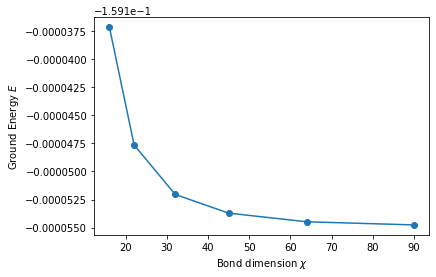

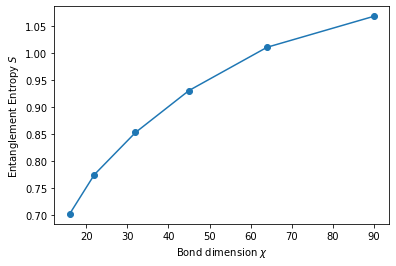

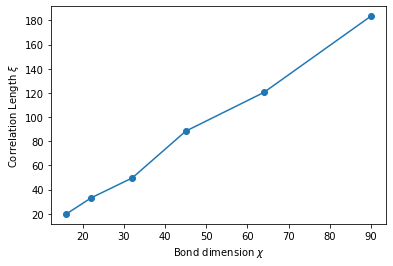

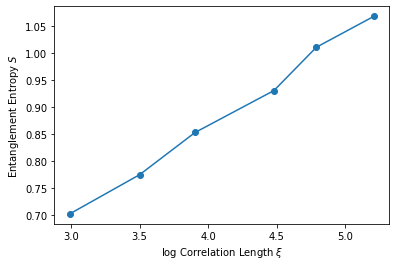

In [9]:
plot_results(data)

## Extract the data and do some demo

In [10]:
chi_list = data['chi_list']
energy_list = data['energy_list']
entropy_list = data['entropy_list']
correlation_list = data['correlation_list']

# entropy_list = entropy_list[0:5]
# correlation_list = correlation_list[0:5]
log_xi = np.log(correlation_list)

print((entropy_list[-1] - entropy_list[0])/(log_xi[-1] - log_xi[0]) * 6)

0.9864913225878007


## Finite Entanglement Scaling
The below content only works for the gapless cases

In [11]:
# from scipy.optimize import curve_fit

# def func(xi, c, a):
#     return (c / 6) * np.log(xi) + a

In [12]:
# xi = correlation_list
# log_xi = np.log(correlation_list)
# s = entropy_list
# fitParams, fitCovariances = curve_fit(func, xi, s)

In [13]:
# fitCovariances